*__Anomaly__ or __outlier detection__ is the identification of abnormal observations.
Our data is composed of only 90 compounds, and one might think that this tiny number is critical to keep.
But careful analysis of available models as well as cross-validation results evidence the existence of
some anomalous items, which thwart learning process. In this notebook, we try to apply anomaly detection
techniques to seek potential outliers.*

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%precision 2

'%.2f'

In [13]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import (
    mutual_info_regression,
    SelectKBest,
    VarianceThreshold,
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from nitrocomchem.featurizer import NonemptyFeatureSelector

We start our analysis on the descriptors generated by **CDK**.

In [4]:
data = pd.read_csv('../data/cdk_descriptors.csv', index_col='Title')
target = pd.read_csv('../data/nitrocom_tasks.csv', usecols=['Log(LD50)'])

data.head()

fragC     ATSc1     ATSc2     ATSc3     ATSc4     ATSc5      ATSm1  \
Title                                                                        
Mol1   415.03  0.057044  0.000557 -0.016223 -0.011508 -0.001291  16.908918   
Mol2   394.05  0.390286 -0.142107 -0.092427  0.070006 -0.052523  17.457856   
Mol3    74.08  0.274688  0.019850 -0.028360 -0.135178 -0.022351  20.821925   
Mol4   146.05  0.103907 -0.002558 -0.018837 -0.009499 -0.050867  20.981849   
Mol5   100.07  0.150663  0.014498 -0.014994 -0.035713 -0.063658  24.530787   

           ATSm2      ATSm3      ATSm4   ...     VAdjMat        VABC  \
Title                                    ...                           
Mol1   17.273105  22.771017  22.826914   ...    5.000000  179.717360   
Mol2   17.601473  20.099385  19.431477   ...    4.906891  164.219235   
Mol3   17.709780  25.869174  28.337902   ...    4.807355  145.183159   
Mol4   14.391058  21.006922  22.338939   ...    4.459432  133.315115   
Mol5   17.497981  25.445575  27.667306   ...    4.700440  148.259109   

          WTPT-1    WTPT-2     WTPT-3     WTPT-4    WTPT-5  WPATH  WPOL  \
Title                                                                     
Mol1   30.315799  2.021053   7.900648   4.852747  3.047901  352.0  21.0   
Mol2   27.715483  1.979677  13.670804  10.640625  3.030179  346.0  16.0   
Mol3   26.932225  1.923730  20.754652   9.650691  6.048343  287.0  21.0   
Mol4   21.235187  1.930472  12.845785   4.818938  5.521368  152.0  14.0   
Mol5   25.090584  1.930045  18.237133   9.654502  6.051643  240.0  18.0   

       Zagreb  
Title          
Mol1     74.0  
Mol2     70.0  
Mol3     68.0  
Mol4     52.0  
Mol5     62.0  

[5 rows x 193 columns]

In [5]:
data.describe()

fragC      ATSc1      ATSc2      ATSc3      ATSc4      ATSc5  \
count    90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean    477.944222   0.296610  -0.119085   0.037201  -0.028798  -0.060521   
std     493.112802   0.201996   0.155514   0.134785   0.093940   0.102641   
min      74.080000   0.057044  -0.581888  -0.199027  -0.322221  -0.386597   
25%     179.042500   0.148166  -0.168947  -0.024049  -0.051499  -0.083022   
50%     287.045000   0.233508  -0.066244  -0.012691  -0.012067  -0.045422   
75%     644.097500   0.383823  -0.001583   0.051300   0.015103  -0.011477   
max    3166.090000   1.172846   0.044550   0.580929   0.196889   0.307383   

           ATSm1      ATSm2      ATSm3      ATSm4     ...        VAdjMat  \
count  90.000000  90.000000  90.000000  90.000000     ...      90.000000   
mean   24.828815  21.638098  30.427168  31.546549     ...       4.989428   
std    11.685017   9.027703  12.406825  14.070031     ...       0.473545   
min    11.908918  11.273105  14.771017  12.660732     ...       4.321928   
25%    15.571644  14.133822  18.850213  19.238354     ...       4.584963   
50%    22.659530  18.924267  27.734129  29.567012     ...       5.000000   
75%    30.198781  26.586726  38.484788  40.667993     ...       5.321928   
max    93.162663  53.710967  78.098977  88.420033     ...       6.357552   

             VABC     WTPT-1     WTPT-2     WTPT-3     WTPT-4     WTPT-5  \
count   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean   197.338994  32.111698   1.953673  17.575714   9.949079   5.483241   
std     71.917069  11.351055   0.037390   6.534976   4.510567   2.922266   
min    118.104047  19.384819   1.907115   7.834411   4.814127   3.014758   
25%    142.965661  23.242463   1.930156  12.848592   7.254371   3.030196   
50%    172.823447  30.086448   1.937401  17.875161   9.647586   5.530167   
75%    245.400553  38.948599   1.976419  21.382693  12.439663   6.079493   
max    501.380131  78.902499   2.063154  46.954112  25.525358  18.860917   

             WPATH       WPOL      Zagreb  
count    90.000000  90.000000   90.000000  
mean    601.688889  24.411111   80.955556  
std     761.445515  11.055422   30.391051  
min     114.000000  11.000000   46.000000  
25%     193.500000  15.000000   56.000000  
50%     353.000000  21.500000   74.000000  
75%     774.000000  29.000000   97.500000  
max    5636.000000  61.000000  194.000000  

[8 rows x 193 columns]

*There are many low-variance features. We will drop them using `VarianceThreshold` selection.*

Let's explore [`IsolationForest`](https://scikit-learn.org/0.19/modules/generated/sklearn.ensemble.IsolationForest.html).

Since actual outliers are unknown, it is impossible to evaluate the model.
So, the hyperparameters of the forest are chosen manually.
While learning random forests, the scores might be helpful to assign to samples.
See `{cdk, dragon, mordred}_analysis.ipynb`.

In [6]:
forest_pipe = make_pipeline(
    VarianceThreshold(0.85 * 0.15),
    IsolationForest(
        n_estimators=1000,
        max_samples=0.8,
        max_features=0.3,
        contamination=0.1,
        bootstrap=False,
        n_jobs=-1,
        random_state=0,
    ),
)
forest_pipe = forest_pipe.fit(data)

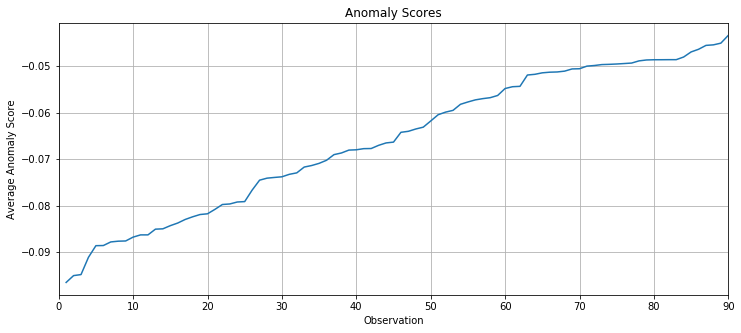

In [7]:
scores = sorted(
    forest_pipe.named_steps['isolationforest'].decision_function(data))

plt.figure(figsize=(12, 5))
plt.title('Anomaly Scores')
plt.xlabel('Observation')
plt.ylabel('Average Anomaly Score')
plt.plot(range(1, 91), scores)
plt.xlim(0, 90)
plt.xticks(range(0, 91, 10))
plt.grid()
plt.show()

*Surprisingly, the isolation forest shows almost no evidence of outliers.*
*Nevertheless, we will try using random forests in cunjunction with isolation forests.*

Now we calculate local outlier factor scores of every compound with
[`LocalOutlierFactor`](https://scikit-learn.org/0.19/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

In [8]:
feature_pipe = make_pipeline(
    NonemptyFeatureSelector(0, 75),
    StandardScaler(),
    SelectKBest(mutual_info_regression, 89),
    PCA(n_components=15, svd_solver='full', whiten=False),
)
lof = LocalOutlierFactor(
    n_neighbors=20,
    metric='minkowski',
    p=2,
    contamination=0.05,
    n_jobs=-1,
)
pipe = make_pipeline(feature_pipe, lof)
outlier_mask = pipe.fit_predict(data, target)

data[outlier_mask == -1]

fragC     ATSc1     ATSc2     ATSc3     ATSc4     ATSc5      ATSm1  \
Title                                                                         
Mol39   535.08  0.386554 -0.260563  0.102521 -0.019508 -0.042455  21.708820   
Mol47  2796.17  1.172846 -0.504008 -0.089859  0.193220 -0.363883  93.162663   
Mol64  1141.06  0.112766 -0.003878 -0.009270  0.013591 -0.066409  23.817837   
Mol68   876.09  0.168144  0.001714  0.035551  0.040569 -0.225870  26.726755   
Mol69  3166.09  0.752178 -0.454945  0.174624 -0.107217  0.130439  40.726755   

           ATSm2      ATSm3      ATSm4   ...     VAdjMat        VABC  \
Title                                    ...                           
Mol39  21.934924  30.568010  27.792907   ...    5.247928  200.109191   
Mol47  53.710967  78.098977  88.420033   ...    6.357552  501.380131   
Mol64  23.546210  38.542034  41.820009   ...    5.392317  259.059460   
Mol68  24.819315  38.313051  44.979287   ...    5.392317  262.764704   
Mol69  41.096567  56.977506  63.366023   ...    6.209453  456.113278   

          WTPT-1    WTPT-2     WTPT-3     WTPT-4     WTPT-5   WPATH  WPOL  \
Title                                                                       
Mol39  35.941201  1.996733  22.707459   4.824207  17.883252   667.0  24.0   
Mol47  78.902499  1.972562  46.954112  25.525358  18.860917  5636.0  61.0   
Mol64  39.103581  1.955179  15.778844   9.693462   6.085383   673.0  38.0   
Mol68  40.091814  1.909134  23.620233  14.514451   9.105782   774.0  39.0   
Mol69  70.135742  2.003878  24.920410  15.635886   9.284524  3884.0  57.0   

       Zagreb  
Title          
Mol39    90.0  
Mol47   194.0  
Mol64   112.0  
Mol68   108.0  
Mol69   176.0  

[5 rows x 193 columns]

In [9]:
data_t = feature_pipe.fit_transform(data, target)

lof.fit(data_t)

LocalOutlierFactor(algorithm='auto', contamination=0.05, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=-1,
          n_neighbors=20, p=2)

In [10]:
lof.kneighbors(data_t[outlier_mask == -1])[0]

array([[ 0.  ,  8.23,  9.46,  9.73, 10.01, 10.4 , 11.34, 11.43, 11.45,
        11.5 , 11.84, 11.86, 11.99, 12.01, 12.05, 12.07, 12.09, 12.2 ,
        12.25, 12.33],
       [ 0.  , 14.15, 20.62, 21.14, 21.27, 21.49, 21.56, 21.6 , 21.79,
        22.24, 23.08, 23.42, 23.86, 23.89, 24.31, 24.4 , 24.52, 24.55,
        24.87, 25.19],
       [ 0.  , 14.61, 14.66, 15.27, 15.37, 16.78, 17.38, 18.61, 18.63,
        18.69, 19.14, 19.28, 19.3 , 19.41, 19.5 , 19.63, 19.64, 19.68,
        19.93, 19.94],
       [ 0.  ,  4.38,  5.51,  6.14, 11.03, 12.06, 12.1 , 12.35, 12.55,
        12.57, 13.34, 13.65, 13.72, 13.92, 14.2 , 14.44, 14.53, 14.72,
        14.73, 14.89],
       [ 0.  , 12.9 , 13.05, 14.15, 15.51, 16.07, 16.91, 17.75, 18.09,
        18.36, 18.43, 18.54, 18.69, 19.36, 19.61, 19.72, 19.95, 20.25,
        20.58, 20.74]])

In [11]:
lof.kneighbors(data_t[outlier_mask == 1])[0]

array([[0.  , 0.64, 3.59, ..., 8.33, 8.42, 8.45],
       [0.  , 3.67, 4.38, ..., 5.98, 6.06, 6.07],
       [0.  , 1.63, 4.15, ..., 5.43, 5.44, 5.45],
       ...,
       [0.  , 0.64, 3.66, ..., 8.3 , 8.31, 8.34],
       [0.  , 5.64, 6.01, ..., 9.67, 9.77, 9.78],
       [0.  , 5.23, 5.84, ..., 8.51, 8.64, 8.67]])

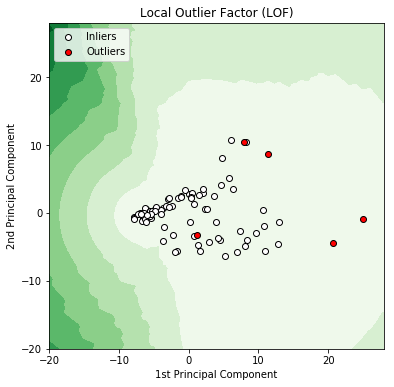

In [12]:
inliers = data_t[outlier_mask == 1]
outliers = data_t[outlier_mask == -1]

linspace = np.linspace(-20, 28, 90)
xx, yy = np.meshgrid(linspace, linspace)

lof.fit(data_t[:, :2])
z = lof._decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure(figsize=(6, 6))

plt.contourf(xx, yy, z, cmap=plt.cm.Greens_r)
i_fig = plt.scatter(inliers[:, 0], inliers[:, 1], c='white', edgecolor='k')
o_fig = plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolor='k')

plt.title('Local Outlier Factor (LOF)')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.axis('tight')
plt.legend([i_fig, o_fig], ['Inliers', 'Outliers'], loc='upper left')
plt.show()